In [ ]:
# 한글 폰트 다운 (다운 완료시 런타임 재시작 수행해주세요!)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [1]:
# 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering 
from sklearn.mixture import GaussianMixture
from matplotlib import rc
from yellowbrick.cluster import SilhouetteVisualizer
import math
import zipfile
import warnings
warnings.filterwarnings('ignore')
rc('font', family='NanumBarunGothic')

In [4]:
주민등록인구_2022 = pd.read_csv('/content/drive/MyDrive/부산 관광 아이디어 공모전/데이터/클러스터링용 데이터/데이터/부산주민등록인구.csv')
인구이동_2022 = pd.read_csv('/content/drive/MyDrive/부산 관광 아이디어 공모전/데이터/클러스터링용 데이터/데이터/부산광역시_시간대_행정동별_인구이동.csv', encoding='cp949')
관광시설_2022 = pd.read_csv('/content/drive/MyDrive/부산 관광 아이디어 공모전/데이터/클러스터링용 데이터/데이터/전처리 데이터/부산광역시_행정동별_관광시설개수.csv')
관광명소_2022 = pd.read_csv('/content/drive/MyDrive/부산 관광 아이디어 공모전/데이터/클러스터링용 데이터/데이터/관광지 수.csv', encoding='cp949')
편의시설_2022 = pd.read_csv('/content/drive/MyDrive/부산 관광 아이디어 공모전/데이터/클러스터링용 데이터/데이터/전처리 데이터/부산광역시_행정동별_편의시설 접근성.csv', encoding='cp949')

In [5]:
주민등록인구_2022

,기준연월,시도명,시군구명,읍면동명,계,남자,여자
0,2022-12-31,부산광역시,중구,중앙동,3137,1445,1692
1,2022-12-31,부산광역시,중구,동광동,2549,1295,1254
2,2022-12-31,부산광역시,중구,대청동,6082,2837,3245
3,2022-12-31,부산광역시,중구,보수동,10345,4983,5362
4,2022-12-31,부산광역시,중구,부평동,4374,2069,2305
...,...,...,...,...,...,...,...
200,2022-12-31,부산광역시,기장군,기장읍,53029,25846,27183
201,2022-12-31,부산광역시,기장군,장안읍,8721,4693,4028
202,2022-12-31,부산광역시,기장군,정관읍,80992,40071,40921
203,2022-12-31,부산광역시,기장군,일광읍,28137,13886,14251


In [6]:
인구이동_2022

,기준연월,시간대,행정동코드,행정동명,이동건수
0,2022-04,0,2611051000,중앙동,323601
1,2022-04,5,2611051000,중앙동,363937
2,2022-04,4,2611051000,중앙동,355988
3,2022-04,3,2611051000,중앙동,341852
4,2022-04,23,2611051000,중앙동,333599
...,...,...,...,...,...
14731,2022-06,4,2671033000,철마면,157441
14732,2022-06,5,2671033000,철마면,168865
14733,2022-06,6,2671033000,철마면,188944
14734,2022-06,18,2671033000,철마면,216091


In [7]:
관광시설_2022

,행정동명,관광시설수
0,중앙동,10
1,동광동,1
2,대청동,0
3,보수동,0
4,부평동,0
...,...,...
200,기장읍,10
201,장안읍,13
202,정관읍,7
203,일광면,3


In [8]:
관광명소_2022

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,NUMPOINTS
0,20210630,2101051,중앙동,426,1
1,20210630,2101052,동광동,427,3
2,20210630,2101053,대청동,428,2
3,20210630,2101054,보수동,429,1
4,20210630,2101056,부평동,430,0
...,...,...,...,...,...
200,20210630,2131011,기장읍,626,9
201,20210630,2131012,장안읍,627,4
202,20210630,2131013,정관읍,628,0
203,20210630,2131031,일광면,629,2


In [9]:
편의시설_2022

,행정동명,병원 수(의료),약국 수(의료),체력단련장업 수(운동),체력도장업 수(운동),요트장업 수(운동),썰매장 수(운동),승마장 수(운동),종합체육시설업 수(운동),수영장 수(운동),...,목욕장 수(생활),은행 수(생활),관광식당 수(식음),관광유흥음식점 수(식음),외국인유흥음식점 수(식음),휴게음식점 수(식음),음식점 수(식음),공원 수(휴식),영화상영관 수(휴식),편의시설 접근성
0,중앙동,3,2,4,0,0,0,0,0,0,...,3,11,0,0,0,94,257,0,0,424
1,동광동,2,2,0,0,0,0,0,0,1,...,3,6,0,0,0,31,161,1,0,226
2,대청동,0,11,1,1,0,0,0,0,0,...,4,0,0,0,0,12,50,0,0,85
3,보수동,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,3,16,0,0,32
4,부평동,0,7,3,0,0,0,0,1,0,...,4,4,0,0,0,43,126,0,0,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,기장읍,5,26,9,24,0,1,0,0,0,...,10,4,0,0,0,272,972,32,7,1492
201,장안읍,0,4,1,2,0,0,0,1,0,...,1,2,0,0,0,84,147,9,0,335
202,정관읍,3,23,20,38,0,0,0,0,1,...,5,5,0,0,0,269,826,34,15,1419
203,일광면,2,9,8,13,0,1,0,1,0,...,4,0,0,0,0,125,372,4,0,556


# **전처리**

## 부산광역시_시간대_행정동별_인구이동

In [10]:
# 행정동 기준연월별 집계 이후, 4~6월 평균값 사용
인구이동_2022_집계 = 인구이동_2022.groupby(["행정동명", '기준연월'], as_index=False)['이동건수'].sum().groupby('행정동명', as_index=False)['이동건수'].mean()

In [11]:
인구이동_2022_집계.loc[인구이동_2022_집계.행정동명 == '일광면', '행정동명'] = '일광읍' # 일광면 -> 일광읍 수정

In [12]:
인구이동_2022_집계

,행정동명,이동건수
0,가덕도동,3.589702e+06
1,가락동,3.118131e+06
2,가야1동,1.624226e+07
3,가야2동,7.384509e+06
4,감만1동,8.057762e+06
...,...,...
200,하단2동,2.090845e+07
201,학장동,1.182250e+07
202,화명1동,1.660439e+07
203,화명2동,1.172076e+07


## 부산광역시_주민등록인구

In [13]:
주민등록인구_2022.읍면동명 = 주민등록인구_2022.읍면동명.str.replace('제','')
주민등록인구_2022.읍면동명 = 주민등록인구_2022.읍면동명.str.replace('거','거제')

In [14]:
주민등록인구_2022

,기준연월,시도명,시군구명,읍면동명,계,남자,여자
0,2022-12-31,부산광역시,중구,중앙동,3137,1445,1692
1,2022-12-31,부산광역시,중구,동광동,2549,1295,1254
2,2022-12-31,부산광역시,중구,대청동,6082,2837,3245
3,2022-12-31,부산광역시,중구,보수동,10345,4983,5362
4,2022-12-31,부산광역시,중구,부평동,4374,2069,2305
...,...,...,...,...,...,...,...
200,2022-12-31,부산광역시,기장군,기장읍,53029,25846,27183
201,2022-12-31,부산광역시,기장군,장안읍,8721,4693,4028
202,2022-12-31,부산광역시,기장군,정관읍,80992,40071,40921
203,2022-12-31,부산광역시,기장군,일광읍,28137,13886,14251


## 부산광역시_관광시설

In [15]:
관광시설_2022.loc[관광시설_2022.행정동명 == '일광면', '행정동명'] = '일광읍' # 일광면 -> 일광읍 수정

In [16]:
관광시설_2022

,행정동명,관광시설수
0,중앙동,10
1,동광동,1
2,대청동,0
3,보수동,0
4,부평동,0
...,...,...
200,기장읍,10
201,장안읍,13
202,정관읍,7
203,일광읍,3


## 부산광역시_관광명소

In [17]:
관광명소_2022.loc[관광명소_2022.ADM_DR_NM == '일광면', 'ADM_DR_NM'] = '일광읍' # 일광면 -> 일광읍 수정

In [18]:
관광명소_2022

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,NUMPOINTS
0,20210630,2101051,중앙동,426,1
1,20210630,2101052,동광동,427,3
2,20210630,2101053,대청동,428,2
3,20210630,2101054,보수동,429,1
4,20210630,2101056,부평동,430,0
...,...,...,...,...,...
200,20210630,2131011,기장읍,626,9
201,20210630,2131012,장안읍,627,4
202,20210630,2131013,정관읍,628,0
203,20210630,2131031,일광읍,629,2


## 관광시설 + 관광명소

In [19]:
merge_df = pd.merge(관광시설_2022, 관광명소_2022, how='inner', left_on='행정동명', right_on='ADM_DR_NM')

In [20]:
merge_df = merge_df[['행정동명', '관광시설수', 'NUMPOINTS']]

In [21]:
관광시설_2022 = pd.DataFrame({'행정동명' : merge_df.행정동명, '관광시설수' : merge_df.관광시설수 + merge_df.NUMPOINTS})

In [22]:
관광시설_2022

,행정동명,관광시설수
0,중앙동,11
1,동광동,4
2,대청동,2
3,보수동,1
4,부평동,0
...,...,...
200,기장읍,19
201,장안읍,17
202,정관읍,7
203,일광읍,5


## 부산광역시_편의시설

In [23]:
# 식음료 업소와 비식음료 업소로 구분 (식음료 업소의 수가 이외 카테고리 편의시설 수에 비해 압도적으로 많기 때문)
식음료_편의시설_2022 = 편의시설_2022[['행정동명', '관광식당 수(식음)', '관광유흥음식점 수(식음)', '외국인유흥음식점 수(식음)', '휴게음식점 수(식음)', '음식점 수(식음)']]
비식음료_편의시설_2022 = 편의시설_2022[['행정동명', '병원 수(의료)', '약국 수(의료)', '체력단련장업 수(운동)', '체력도장업 수(운동)',
       '요트장업 수(운동)', '썰매장 수(운동)', '승마장 수(운동)', '종합체육시설업 수(운동)', '수영장 수(운동)',
       '빙상장 수(운동)', '무도학원업 수(운동)', '당구장 수(운동)', '골프장 수(운동)', '골프연습장 수(운동)',
       '등록체육시설업 수(운동)', '대규모점포 수(구매)', '편의점 수(구매)', '버스정류장 수(교통)', '지하철 수(교통)',
       '세탁업 수(생활)', '목욕장 수(생활)', '은행 수(생활)', '공원 수(휴식)', '영화상영관 수(휴식)']]

In [24]:
편의시설_2022 = pd.DataFrame({'행정동명' : 식음료_편의시설_2022.행정동명,
 '식음료_편의시설수' : 식음료_편의시설_2022.loc[:, 식음료_편의시설_2022.columns != '행정동명'].sum(axis=1),
 '비식음료_편의시설수' : 비식음료_편의시설_2022.loc[:, 비식음료_편의시설_2022.columns != '행정동명'].sum(axis=1)})

In [25]:
편의시설_2022.loc[편의시설_2022.행정동명 == '일광면', '행정동명'] = '일광읍' # 일광면 -> 일광읍 수정

In [26]:
편의시설_2022

,행정동명,식음료_편의시설수,비식음료_편의시설수
0,중앙동,351,73
1,동광동,192,34
2,대청동,62,23
3,보수동,19,13
4,부평동,169,36
...,...,...,...
200,기장읍,1244,248
201,장안읍,231,104
202,정관읍,1095,324
203,일광읍,497,59


# 데이터 병합

## 유동인구/주민등록인구 + 식음료, 비식음료 분리 version.

In [27]:
# 주민등록인구 데이터를 기준으로 병합
df1 = pd.merge(주민등록인구_2022, 인구이동_2022_집계, how='inner', left_on='읍면동명', right_on='행정동명')
df1 = df1[['행정동명', '계', '이동건수']]
df1.columns = ['행정동명', '주민등록인구', '유동인구']
df1['주민대비유동인구'] = (df1.유동인구 / df1.주민등록인구)

df2 = pd.merge(df1, 관광시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

유동인구_주민등록인구_식음료_비식음료_분리 = pd.merge(df2, 편의시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

In [28]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
유동인구_주민등록인구_식음료_비식음료_분리_sc = scaler.fit_transform(유동인구_주민등록인구_식음료_비식음료_분리[['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']])

In [29]:
유동인구_주민등록인구_식음료_비식음료_분리_sc = pd.concat([유동인구_주민등록인구_식음료_비식음료_분리.행정동명, pd.DataFrame(유동인구_주민등록인구_식음료_비식음료_분리_sc, columns = ['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수'])], axis=1)

In [30]:
유동인구_주민등록인구_식음료_비식음료_분리_sc

,행정동명,주민대비유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수
0,중앙동,3.858337,3.103892,0.363194,0.258735
1,동광동,0.119724,0.714361,-0.269363,-0.561481
2,대청동,0.262433,0.031638,-0.786548,-0.792824
3,보수동,-0.302982,-0.309723,-0.957616,-1.003136
4,부평동,1.712188,-0.651085,-0.360865,-0.519419
...,...,...,...,...,...
200,기장읍,-0.029922,5.834783,3.915854,3.939191
201,장안읍,0.703730,5.152060,-0.114208,0.910701
202,정관읍,-0.259660,1.738446,3.323081,5.537561
203,일광읍,-0.344348,1.055723,0.944032,-0.035702


## 유동인구/주민등록인구 + 식음료, 비식음료 통합 version.

In [31]:
# 주민등록인구 데이터를 기준으로 병합
df1 = pd.merge(주민등록인구_2022, 인구이동_2022_집계, how='inner', left_on='읍면동명', right_on='행정동명')
df1 = df1[['행정동명', '계', '이동건수']]
df1.columns = ['행정동명', '주민등록인구', '유동인구']
df1['주민대비유동인구'] = (df1.유동인구 / df1.주민등록인구)

df2 = pd.merge(df1, 관광시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

유동인구_주민등록인구_식음료_비식음료_통합 = pd.merge(df2, 편의시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

# 식음료/비식음료 통합
유동인구_주민등록인구_식음료_비식음료_통합['편의시설수'] = 유동인구_주민등록인구_식음료_비식음료_통합.식음료_편의시설수 + 유동인구_주민등록인구_식음료_비식음료_통합.비식음료_편의시설수

In [32]:
유동인구_주민등록인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,주민대비유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수
0,중앙동,3137,1.184454e+07,3775.754649,11,351,73,424
1,동광동,2549,2.188580e+06,858.603243,4,192,34,226
2,대청동,6082,5.899270e+06,969.955662,2,62,23,85
3,보수동,10345,5.470184e+06,528.775640,1,19,13,32
4,부평동,4374,9.190497e+06,2101.165295,0,169,36,205
...,...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,741.838353,19,1244,248,1492
201,장안읍,8721,1.146192e+07,1314.289416,17,231,104,335
202,정관읍,80992,4.556442e+07,562.579267,7,1095,324,1419
203,일광읍,28137,1.396999e+07,496.498792,5,497,59,556


In [33]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
유동인구_주민등록인구_식음료_비식음료_통합_sc = scaler.fit_transform(유동인구_주민등록인구_식음료_비식음료_통합[['주민대비유동인구', '관광시설수', '편의시설수']])

In [34]:
유동인구_주민등록인구_식음료_비식음료_통합_sc = pd.concat([유동인구_주민등록인구_식음료_비식음료_통합.행정동명, pd.DataFrame(유동인구_주민등록인구_식음료_비식음료_통합_sc, columns = ['주민대비유동인구', '관광시설수', '편의시설수'])], axis=1)

In [35]:
유동인구_주민등록인구_식음료_비식음료_통합_sc

,행정동명,주민대비유동인구,관광시설수,편의시설수
0,중앙동,3.858337,3.103892,0.352156
1,동광동,0.119724,0.714361,-0.320915
2,대청동,0.262433,0.031638,-0.800223
3,보수동,-0.302982,-0.309723,-0.980388
4,부평동,1.712188,-0.651085,-0.392301
...,...,...,...,...
200,기장읍,-0.029922,5.834783,3.982657
201,장안읍,0.703730,5.152060,0.049614
202,정관읍,-0.259660,1.738446,3.734505
203,일광읍,-0.344348,1.055723,0.800869


## 단순 유동인구 + 식음료, 비식음료 분리 version.

In [36]:
# 주민등록인구 데이터를 기준으로 병합
df1 = pd.merge(주민등록인구_2022, 인구이동_2022_집계, how='inner', left_on='읍면동명', right_on='행정동명')
df1 = df1[['행정동명', '계', '이동건수']]
df1.columns = ['행정동명', '주민등록인구', '유동인구']

df2 = pd.merge(df1, 관광시설_2022, how='inner', left_on='행정동명', right_on='행정동명')
유동인구_식음료_비식음료_분리 = pd.merge(df2, 편의시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

In [37]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
유동인구_식음료_비식음료_분리_sc = scaler.fit_transform(유동인구_식음료_비식음료_분리[['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']])

In [38]:
유동인구_식음료_비식음료_분리_sc = pd.concat([유동인구_식음료_비식음료_분리.행정동명, pd.DataFrame(유동인구_식음료_비식음료_분리_sc, columns = ['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수'])], axis=1)

In [39]:
유동인구_식음료_비식음료_분리_sc

,행정동명,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수
0,중앙동,0.147108,3.103892,0.363194,0.258735
1,동광동,-1.188572,0.714361,-0.269363,-0.561481
2,대청동,-0.675284,0.031638,-0.786548,-0.792824
3,보수동,-0.734638,-0.309723,-0.957616,-1.003136
4,부평동,-0.220018,-0.651085,-0.360865,-0.519419
...,...,...,...,...,...
200,기장읍,3.950324,5.834783,3.915854,3.939191
201,장안읍,0.094180,5.152060,-0.114208,0.910701
202,정관읍,4.811474,1.738446,3.323081,5.537561
203,일광읍,0.441114,1.055723,0.944032,-0.035702


## 단순 유동인구 + 식음료, 비식음료 통합 version.

In [40]:
# 주민등록인구 데이터를 기준으로 병합
df1 = pd.merge(주민등록인구_2022, 인구이동_2022_집계, how='inner', left_on='읍면동명', right_on='행정동명')
df1 = df1[['행정동명', '계', '이동건수']]
df1.columns = ['행정동명', '주민등록인구', '유동인구']

df2 = pd.merge(df1, 관광시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

유동인구_식음료_비식음료_통합 = pd.merge(df2, 편의시설_2022, how='inner', left_on='행정동명', right_on='행정동명')

# 식음료/비식음료 통합
유동인구_식음료_비식음료_통합['편의시설수'] = 유동인구_식음료_비식음료_통합.식음료_편의시설수 + 유동인구_식음료_비식음료_통합.비식음료_편의시설수

In [44]:
유동인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수
0,중앙동,3137,1.184454e+07,11,351,73,424
1,동광동,2549,2.188580e+06,4,192,34,226
2,대청동,6082,5.899270e+06,2,62,23,85
3,보수동,10345,5.470184e+06,1,19,13,32
4,부평동,4374,9.190497e+06,0,169,36,205
...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,19,1244,248,1492
201,장안읍,8721,1.146192e+07,17,231,104,335
202,정관읍,80992,4.556442e+07,7,1095,324,1419
203,일광읍,28137,1.396999e+07,5,497,59,556


In [41]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
유동인구_식음료_비식음료_통합_sc = scaler.fit_transform(유동인구_식음료_비식음료_통합[['유동인구', '관광시설수', '편의시설수']])

In [42]:
유동인구_식음료_비식음료_통합_sc = pd.concat([유동인구_식음료_비식음료_통합.행정동명, pd.DataFrame(유동인구_식음료_비식음료_통합_sc, columns = ['유동인구', '관광시설수', '편의시설수'])], axis=1)

In [43]:
유동인구_식음료_비식음료_통합_sc

,행정동명,유동인구,관광시설수,편의시설수
0,중앙동,0.147108,3.103892,0.352156
1,동광동,-1.188572,0.714361,-0.320915
2,대청동,-0.675284,0.031638,-0.800223
3,보수동,-0.734638,-0.309723,-0.980388
4,부평동,-0.220018,-0.651085,-0.392301
...,...,...,...,...
200,기장읍,3.950324,5.834783,3.982657
201,장안읍,0.094180,5.152060,0.049614
202,정관읍,4.811474,1.738446,3.734505
203,일광읍,0.441114,1.055723,0.800869


# 클러스터링

## 유동인구/주민등록인구 + 식음료, 비식음료 분리 version.

In [ ]:
def plot_Silhouette(data,  k, text):
    km = KMeans(n_clusters=k, init='k-means++', random_state=2023)
    km.fit(data)

    fig = plt.figure()
    fig.set_size_inches(15, 5)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data)

    visualizer.ax.set_title(text,fontsize=15, weight='bold')
    visualizer.ax.set_xlabel("Silhouette Value",fontsize=15, weight='bold')
    visualizer.ax.set_ylabel("군집",fontsize=15, weight='bold')
    visualizer.ax.set_yticks([])

    plt.show()

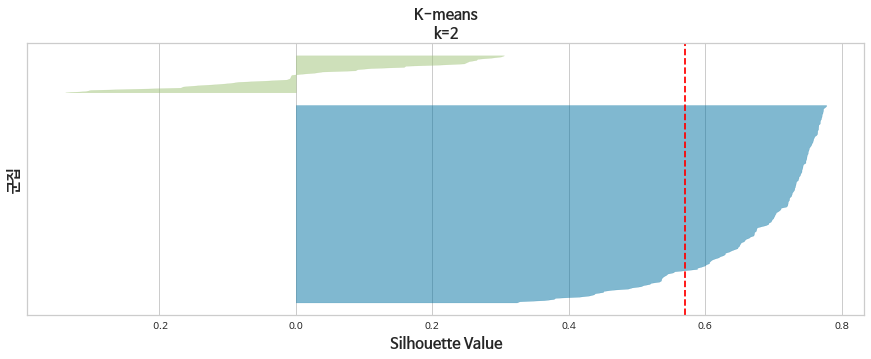

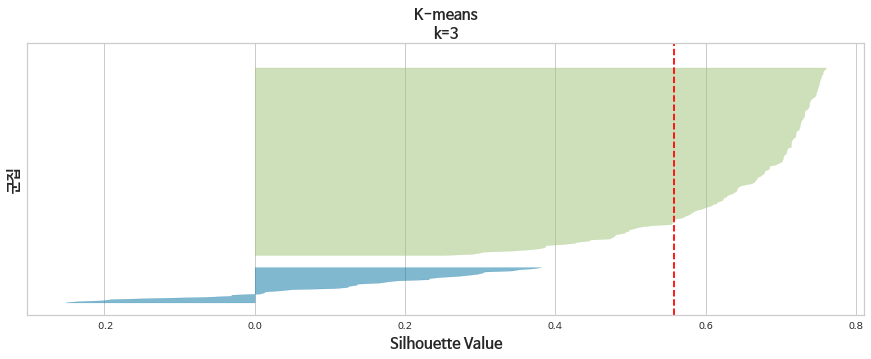

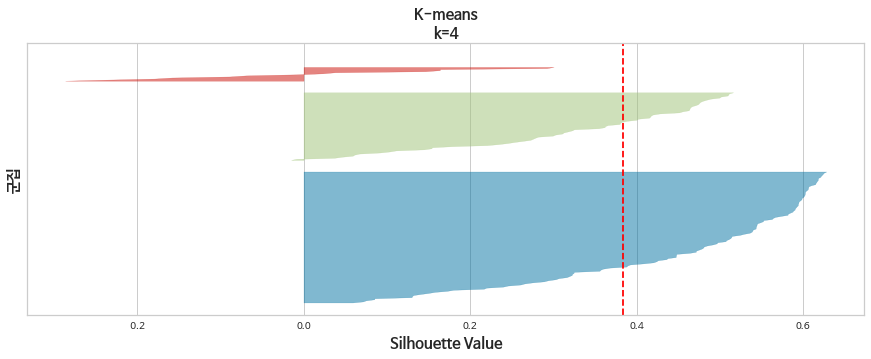

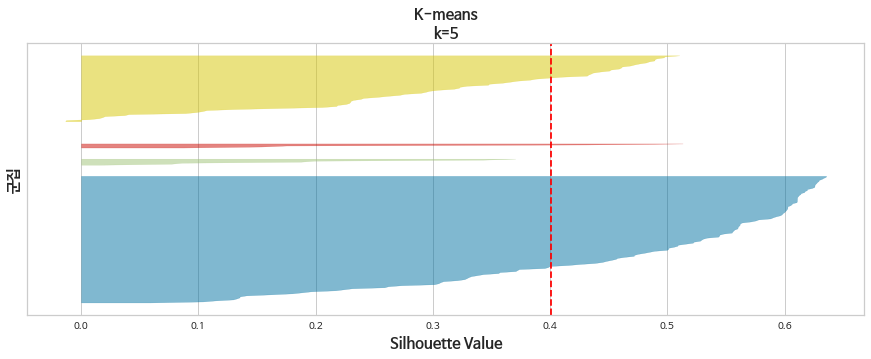

In [ ]:
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 2, 'K-means\nk=2')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 3, 'K-means\nk=3')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 4, 'K-means\nk=4')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 5, 'K-means\nk=5')

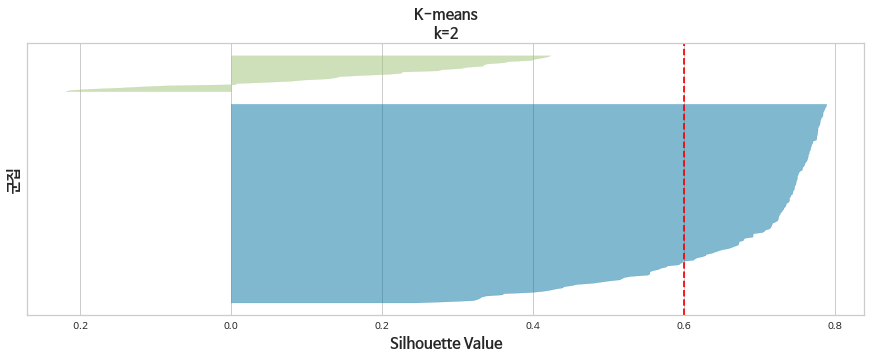

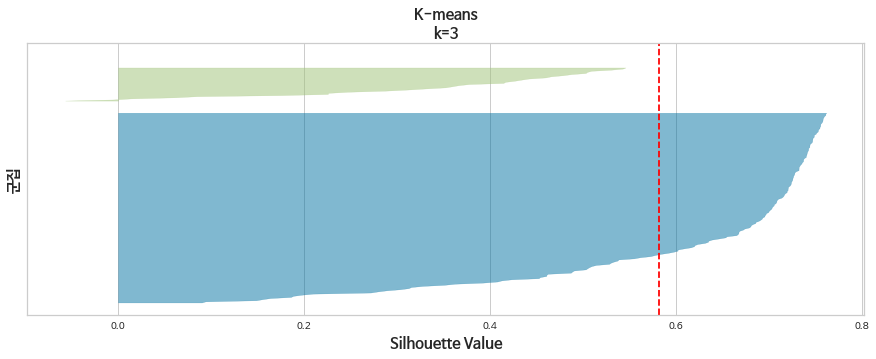

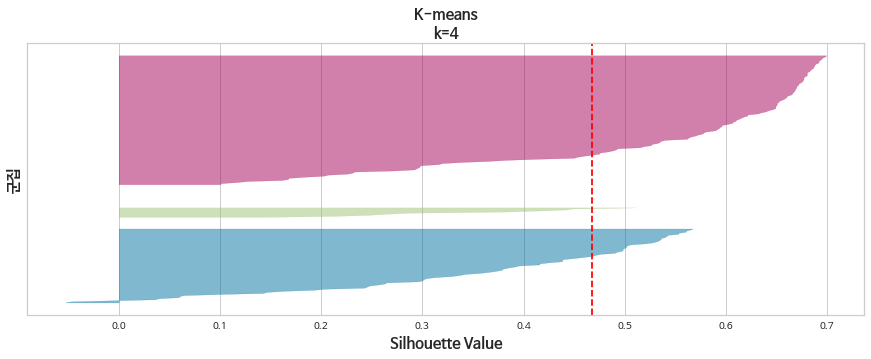

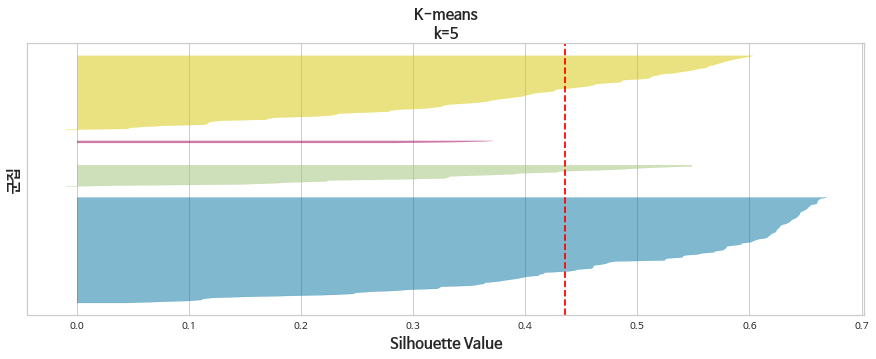

In [ ]:
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '식음료_편의시설수',	'비식음료_편의시설수']], 2, 'K-means\nk=2')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '식음료_편의시설수',	'비식음료_편의시설수']], 3, 'K-means\nk=3')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '식음료_편의시설수',	'비식음료_편의시설수']], 4, 'K-means\nk=4')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_분리_sc[['주민대비유동인구', '식음료_편의시설수',	'비식음료_편의시설수']], 5, 'K-means\nk=5')

## 유동인구/주민등록인구 + 식음료, 비식음료 통합 version.

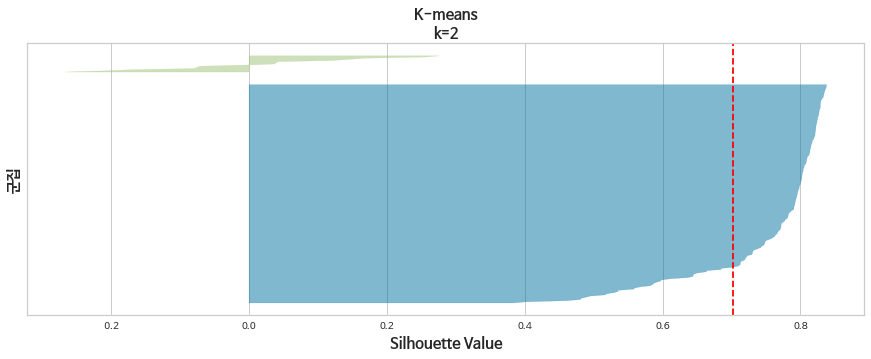

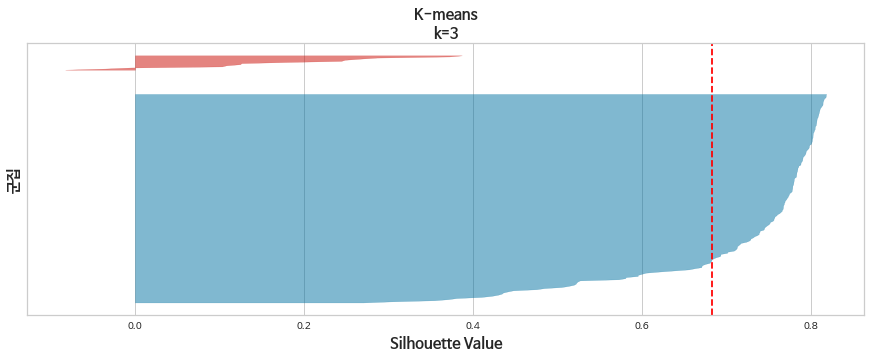

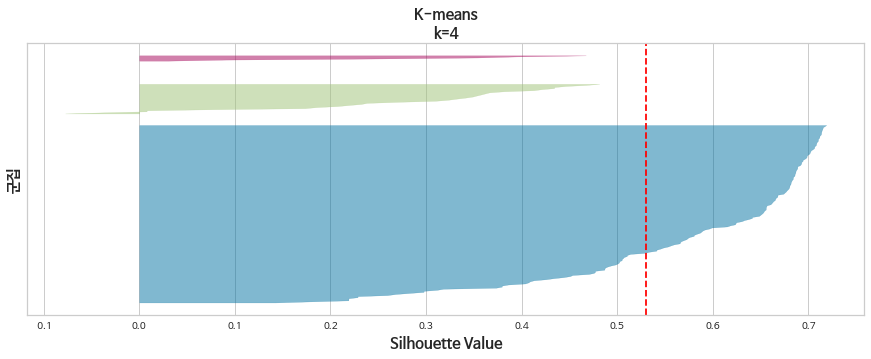

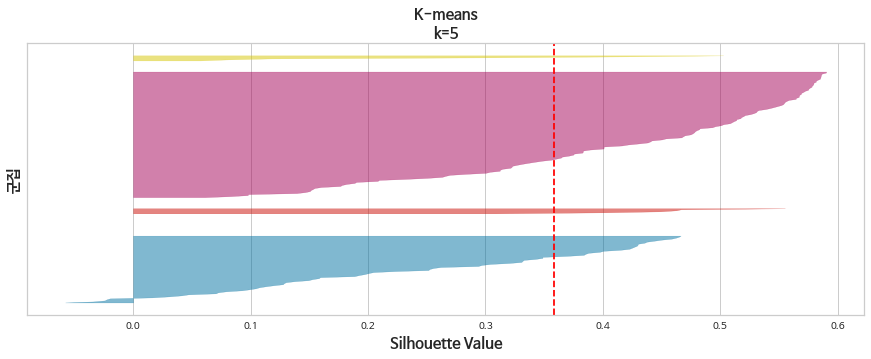

In [ ]:
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_통합_sc[['주민대비유동인구', '관광시설수', '편의시설수']], 2, 'K-means\nk=2')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_통합_sc[['주민대비유동인구', '관광시설수', '편의시설수']], 3, 'K-means\nk=3')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_통합_sc[['주민대비유동인구', '관광시설수', '편의시설수']], 4, 'K-means\nk=4')
plot_Silhouette(유동인구_주민등록인구_식음료_비식음료_통합_sc[['주민대비유동인구', '관광시설수', '편의시설수']], 5, 'K-means\nk=5')

## 단순 유동인구 + 식음료, 비식음료 분리 version.

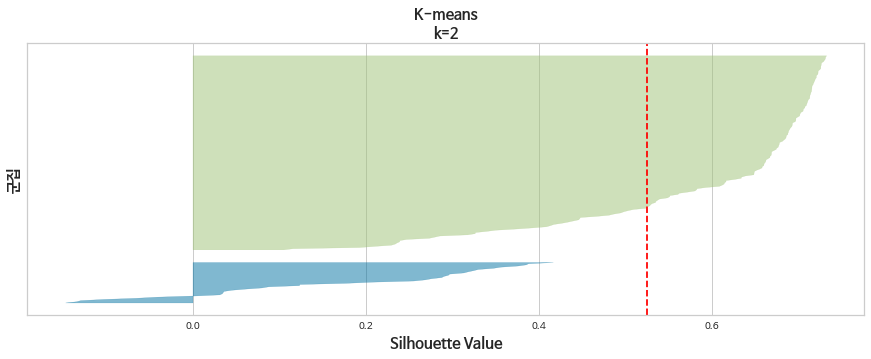

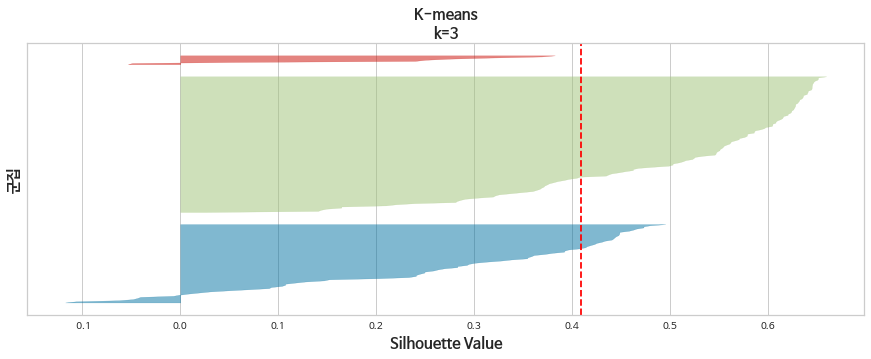

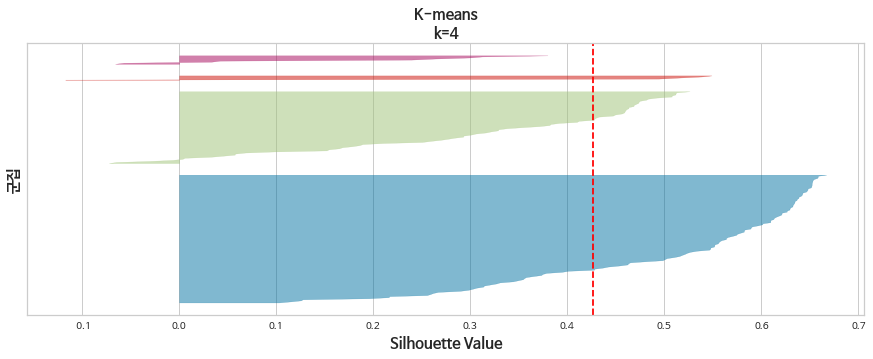

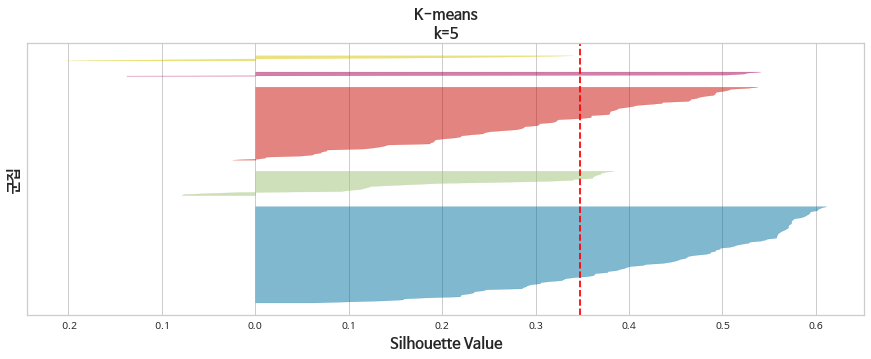

In [ ]:
plot_Silhouette(유동인구_식음료_비식음료_분리_sc[['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 2, 'K-means\nk=2')
plot_Silhouette(유동인구_식음료_비식음료_분리_sc[['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 3, 'K-means\nk=3')
plot_Silhouette(유동인구_식음료_비식음료_분리_sc[['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 4, 'K-means\nk=4')
plot_Silhouette(유동인구_식음료_비식음료_분리_sc[['유동인구', '관광시설수', '식음료_편의시설수',	'비식음료_편의시설수']], 5, 'K-means\nk=5')

## 단순 유동인구 + 식음료, 비식음료 통합 version.

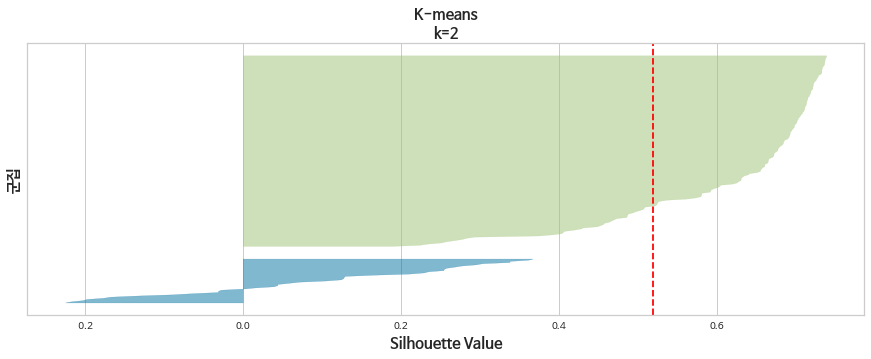

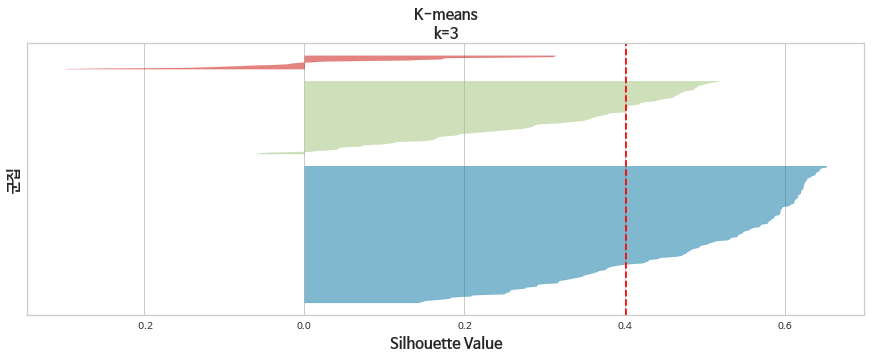

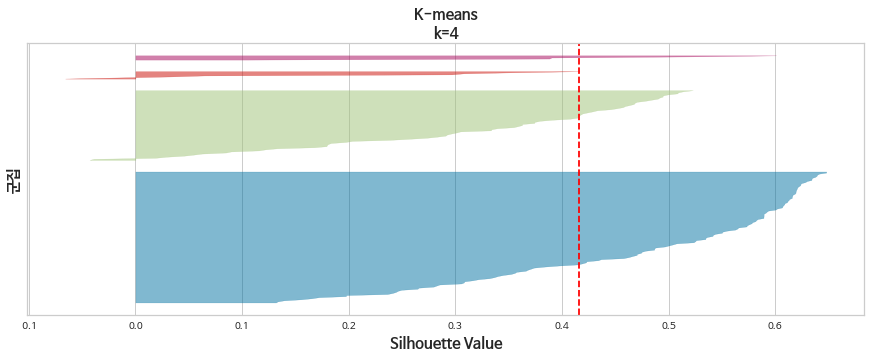

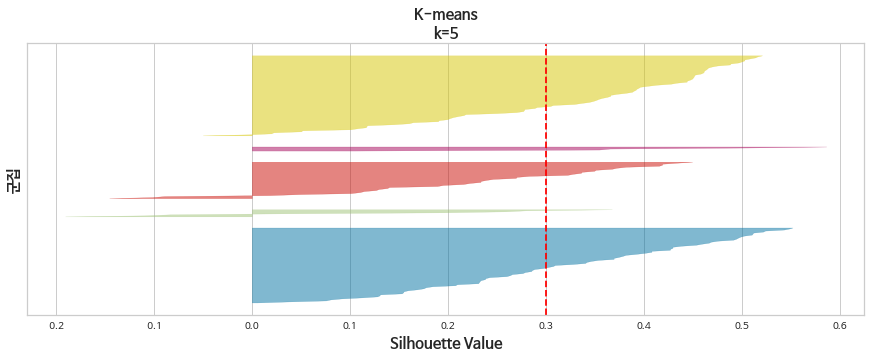

In [ ]:
plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 2, 'K-means\nk=2')
plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 3, 'K-means\nk=3')
plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 4, 'K-means\nk=4')
plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 5, 'K-means\nk=5')

단순히 유동인구를 클러스터링 변수로 사용하는 경우가, 유동/주민등록 변수를 사용하는 것보다 클러스터링이 우수하게 진행된다.<br>

식음료/비식음료 업소를 분리하는지, 통합하는지 여부는 클러스터링에서 크게 영향을 미치진 않는 것으로 판단되며, 그래도 실루엣계수 상으로 통합했을 때가 좀 더 낫다고 판단된다.<br>

또한 나누어진 군집별 클러스터들을 살펴보았을 때, 군집 4개 정도가 적당해보인다.<br>


최종적으로, 클러스터링 변수는 **유동인구, 관광시설수, 편의시설수**, 적정 클러스터 수는 **4개**로 진행해보자!

In [ ]:
km = KMeans(n_clusters=4, init='k-means++', random_state=2023).fit(유동인구_식음료_비식음료_통합_sc.loc[:, 유동인구_식음료_비식음료_통합_sc.columns != '행정동명'])

유동인구_식음료_비식음료_통합['K_means_군집'] = km.predict(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']])

In [ ]:
유동인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집
0,중앙동,3137,1.184454e+07,11,351,73,424,3
1,동광동,2549,2.188580e+06,4,192,34,226,0
2,대청동,6082,5.899270e+06,2,62,23,85,0
3,보수동,10345,5.470184e+06,1,19,13,32,0
4,부평동,4374,9.190497e+06,0,169,36,205,0
...,...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,19,1244,248,1492,2
201,장안읍,8721,1.146192e+07,17,231,104,335,3
202,정관읍,80992,4.556442e+07,7,1095,324,1419,2
203,일광읍,28137,1.396999e+07,5,497,59,556,1


In [ ]:
유동인구_식음료_비식음료_통합_군집0 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_means_군집 == 0, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집1 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_means_군집 == 1, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집2 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_means_군집 == 2, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집3 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_means_군집 == 3, :].reset_index(drop=True)

In [ ]:
유동인구_식음료_비식음료_통합_군집0

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집
0,동광동,2549,2.188580e+06,4,192,34,226,0
1,대청동,6082,5.899270e+06,2,62,23,85,0
2,보수동,10345,5.470184e+06,1,19,13,32,0
3,부평동,4374,9.190497e+06,0,169,36,205,0
4,광복동,941,1.802619e+06,5,213,36,249,0
...,...,...,...,...,...,...,...,...
120,덕포1동,8392,3.406019e+06,0,140,38,178,0
121,덕포2동,12583,8.274128e+06,4,88,50,138,0
122,주례1동,16182,1.004792e+07,0,84,35,119,0
123,주례3동,12643,4.524844e+06,0,219,49,268,0


In [ ]:
유동인구_식음료_비식음료_통합_군집1

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집
0,남포동,853,8.994932e+06,0,458,55,513,1
1,서대신1동,14808,1.125333e+07,6,297,69,366,1
2,초량3동,12983,1.134434e+07,4,474,80,554,1
3,범일2동,7837,1.222985e+07,7,590,108,698,1
4,남항동,10621,1.006020e+07,1,462,61,523,1
...,...,...,...,...,...,...,...,...
62,감전동,12787,1.158944e+07,1,441,107,548,1
63,주례2동,22192,1.991232e+07,1,347,81,428,1
64,학장동,27425,1.182250e+07,1,286,102,388,1
65,엄궁동,25411,1.626436e+07,0,275,96,371,1


In [ ]:
유동인구_식음료_비식음료_통합_군집2

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집
0,부전2동,10699,2.241646e+07,6,1862,249,2111,2
1,대연3동,33110,3.491832e+07,4,1104,164,1268,2
2,장전2동,26049,2.294233e+07,5,1022,132,1154,2
3,명지1동,53652,2.923121e+07,5,1032,173,1205,2
4,녹산동,35747,3.829752e+07,2,599,211,810,2
5,괘법동,23504,1.894778e+07,8,860,157,1017,2
6,기장읍,53029,3.933895e+07,19,1244,248,1492,2
7,정관읍,80992,4.556442e+07,7,1095,324,1419,2


In [ ]:
유동인구_식음료_비식음료_통합_군집2.행정동명.tolist()

['부전2동', '대연3동', '장전2동', '명지1동', '녹산동', '괘법동', '기장읍', '정관읍']

In [ ]:
유동인구_식음료_비식음료_통합_군집3

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집
0,중앙동,3137,1.184454e+07,11,351,73,424,3
1,아미동,6181,3.942623e+06,16,136,43,179,3
2,암남동,14649,1.245951e+07,11,223,61,284,3
3,우2동,30274,2.921731e+07,16,743,178,921,3
4,장안읍,8721,1.146192e+07,17,231,104,335,3


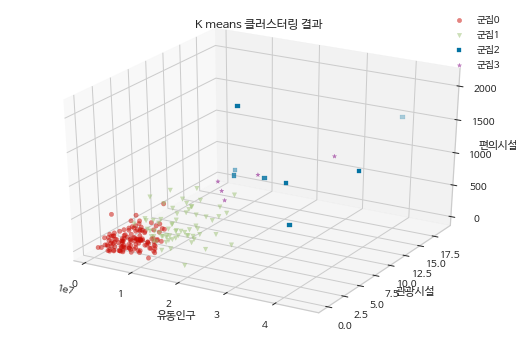

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(유동인구_식음료_비식음료_통합_군집0.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집0.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집0.편의시설수.tolist(), color = 'r', alpha = 0.5, marker='o', label='군집0')
ax.scatter(유동인구_식음료_비식음료_통합_군집1.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집1.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집1.편의시설수.tolist(), color = 'g', alpha = 0.5, marker='v', label='군집1')
ax.scatter(유동인구_식음료_비식음료_통합_군집2.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집2.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집2.편의시설수.tolist(), color = 'b', marker='s', label='군집2')
ax.scatter(유동인구_식음료_비식음료_통합_군집3.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집3.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집3.편의시설수.tolist(), color = 'purple', alpha = 0.5, marker='*', label='군집3')

ax.set_xlabel('유동인구')
ax.set_ylabel('관광시설')
ax.set_zlabel('편의시설')

plt.title('K means 클러스터링 결과')
plt.legend()
plt.show()

유동인구도 많고, 관광시설과 편의시설이 풍부한 군집2을 Target으로 삼는 것이 좋아보인다.<br>

그렇다면 Target 행정동은 3가지 클러스터 변수가 가장 많은 위치로 선정하는 것을 목표로 하며, 다양한 클러스터링을 통한 Voting을 통해 선정하는 과정을 진행한다.

In [ ]:
# 전체 실루엣계수 평균 출력
labels = km.labels_

silhouette_score(유동인구_식음료_비식음료_통합_sc.loc[:, 유동인구_식음료_비식음료_통합_sc.columns != '행정동명'], labels, metric='euclidean')

0.4155600506612999

# Voting을 위한 추가 클러스터링

## K-medoids

In [ ]:
# K-medoids 클러스터링
def k_medoids_plot_Silhouette(data,  k, text):
    km = KMedoids(n_clusters=k, init='k-medoids++', random_state=2023)
    km.fit(data)

    fig = plt.figure()
    fig.set_size_inches(15, 5)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data)

    visualizer.ax.set_title(text,fontsize=15, weight='bold')
    visualizer.ax.set_xlabel("Silhouette Value",fontsize=15, weight='bold')
    visualizer.ax.set_ylabel("군집",fontsize=15, weight='bold')
    visualizer.ax.set_yticks([])

    plt.show()

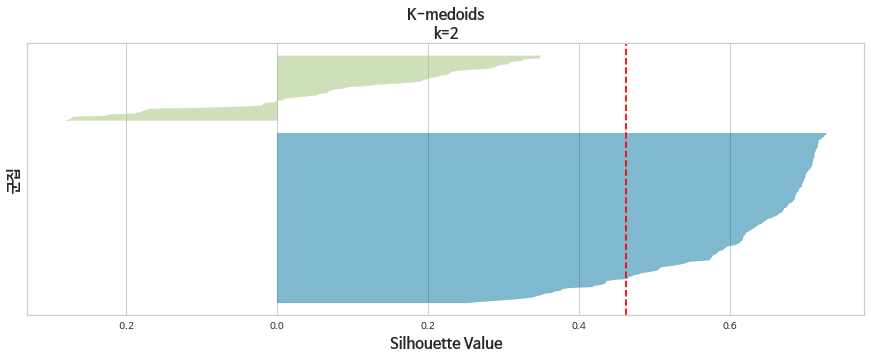

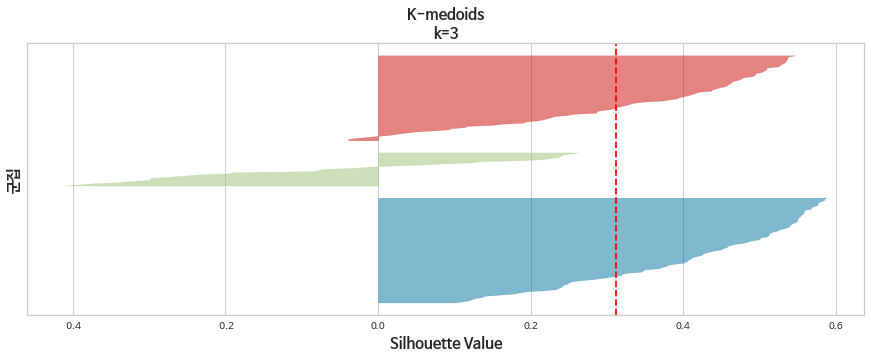

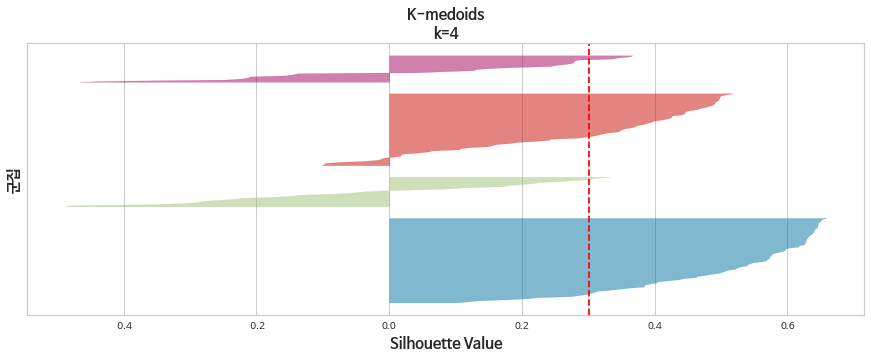

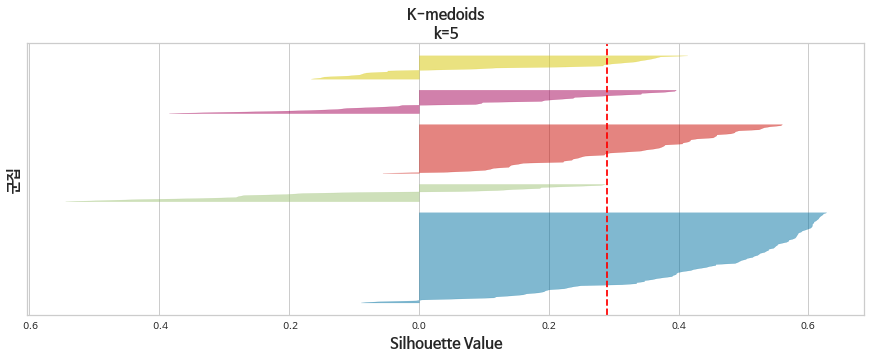

In [ ]:
k_medoids_plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 2, 'K-medoids\nk=2')
k_medoids_plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 3, 'K-medoids\nk=3')
k_medoids_plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 4, 'K-medoids\nk=4')
k_medoids_plot_Silhouette(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], 5, 'K-medoids\nk=5')

In [ ]:
km = KMedoids(n_clusters=4, init='k-medoids++', random_state=2023).fit(유동인구_식음료_비식음료_통합_sc.loc[:, 유동인구_식음료_비식음료_통합_sc.columns != '행정동명'])

유동인구_식음료_비식음료_통합['K_medoids_군집'] = km.predict(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']])

In [ ]:
유동인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집,K_medoids_군집
0,중앙동,3137,1.184454e+07,11,351,73,424,3,3
1,동광동,2549,2.188580e+06,4,192,34,226,0,3
2,대청동,6082,5.899270e+06,2,62,23,85,0,0
3,보수동,10345,5.470184e+06,1,19,13,32,0,0
4,부평동,4374,9.190497e+06,0,169,36,205,0,0
...,...,...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,19,1244,248,1492,2,1
201,장안읍,8721,1.146192e+07,17,231,104,335,3,3
202,정관읍,80992,4.556442e+07,7,1095,324,1419,2,1
203,일광읍,28137,1.396999e+07,5,497,59,556,1,1


In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 1, '행정동명'].tolist()

['범일2동',
 '부전2동',
 '전포1동',
 '수민동',
 '명륜동',
 '온천1동',
 '온천3동',
 '대연3동',
 '용호1동',
 '화명3동',
 '우1동',
 '우2동',
 '중1동',
 '좌2동',
 '반여1동',
 '재송1동',
 '하단1동',
 '하단2동',
 '다대1동',
 '장전2동',
 '남산동',
 '명지1동',
 '녹산동',
 '거제1동',
 '연산9동',
 '괘법동',
 '기장읍',
 '정관읍',
 '일광읍']

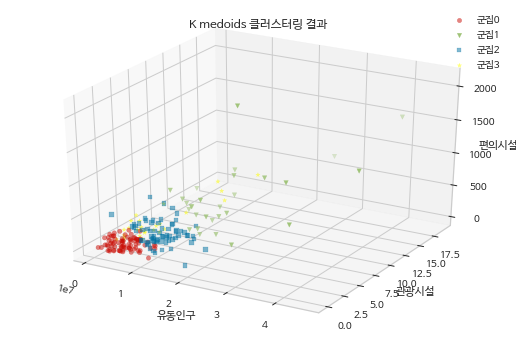

In [ ]:
유동인구_식음료_비식음료_통합_군집0 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 0, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집1 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 1, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집2 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 2, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집3 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 3, :].reset_index(drop=True)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(유동인구_식음료_비식음료_통합_군집0.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집0.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집0.편의시설수.tolist(), color = 'r', alpha = 0.5, marker='o', label='군집0')
ax.scatter(유동인구_식음료_비식음료_통합_군집1.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집1.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집1.편의시설수.tolist(), color = 'g', marker='v', label='군집1')
ax.scatter(유동인구_식음료_비식음료_통합_군집2.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집2.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집2.편의시설수.tolist(), color = 'b', alpha = 0.5, marker='s', label='군집2')
ax.scatter(유동인구_식음료_비식음료_통합_군집3.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집3.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집3.편의시설수.tolist(), color = 'yellow', alpha = 0.5, marker='*', label='군집3')

ax.set_xlabel('유동인구')
ax.set_ylabel('관광시설')
ax.set_zlabel('편의시설')

plt.title('K medoids 클러스터링 결과')
plt.legend()
plt.show()

## 계층적 클러스터링

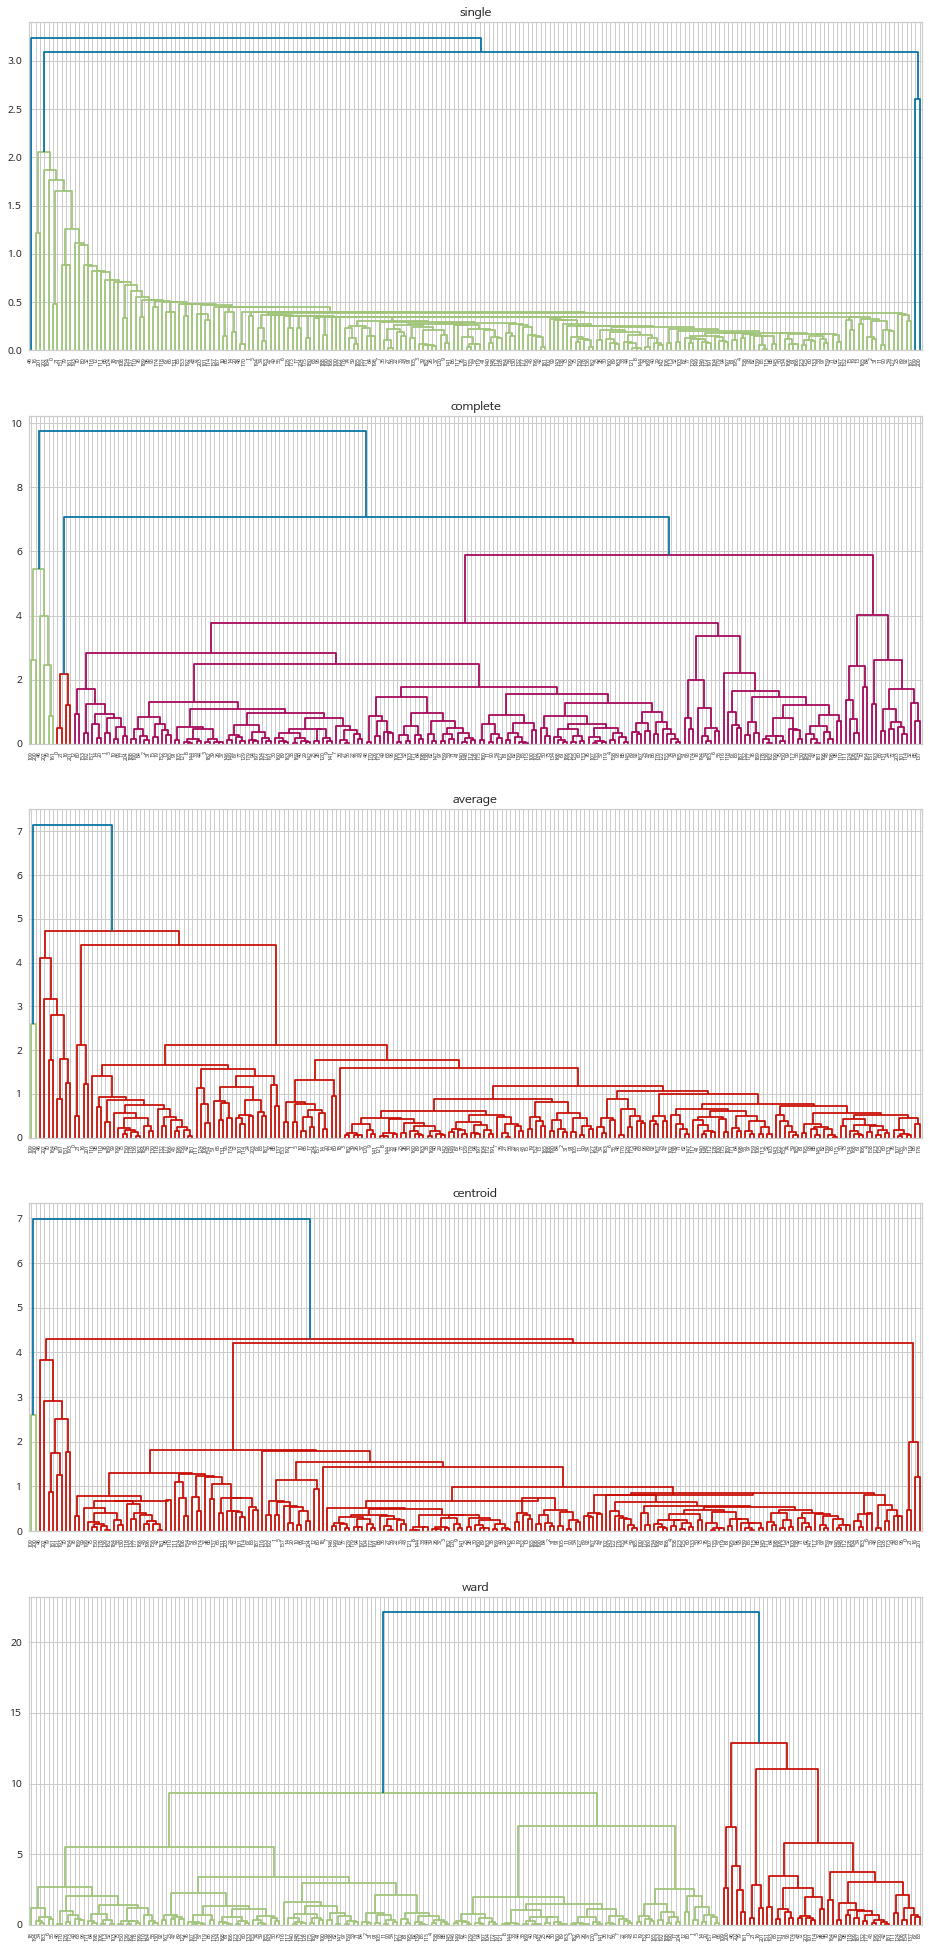

In [ ]:
linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=1, figsize=(16, 35))
for i in range(len(linkage_list)):
  hierarchical_single = linkage(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']], method=linkage_list[i])
  dn = dendrogram(hierarchical_single, ax=axes[i])
  axes[i].title.set_text(linkage_list[i])
plt.show()

In [ ]:
# 다시 fitting
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels = agg_clustering.fit_predict(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']])

유동인구_식음료_비식음료_통합['계층적_군집'] = labels

In [ ]:
유동인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집,K_medoids_군집,계층적_군집
0,중앙동,3137,1.184454e+07,11,351,73,424,3,3,2
1,동광동,2549,2.188580e+06,4,192,34,226,0,3,3
2,대청동,6082,5.899270e+06,2,62,23,85,0,0,3
3,보수동,10345,5.470184e+06,1,19,13,32,0,0,3
4,부평동,4374,9.190497e+06,0,169,36,205,0,0,3
...,...,...,...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,19,1244,248,1492,2,1,0
201,장안읍,8721,1.146192e+07,17,231,104,335,3,3,2
202,정관읍,80992,4.556442e+07,7,1095,324,1419,2,1,0
203,일광읍,28137,1.396999e+07,5,497,59,556,1,1,1


In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 0, '행정동명'].tolist()

['부전2동', '대연3동', '우2동', '명지1동', '기장읍', '정관읍']

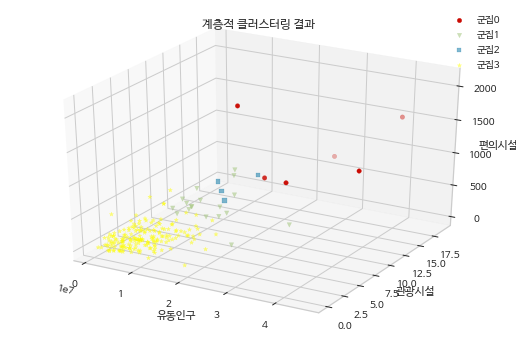

In [ ]:
유동인구_식음료_비식음료_통합_군집0 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 0, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집1 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 1, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집2 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 2, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집3 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 3, :].reset_index(drop=True)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(유동인구_식음료_비식음료_통합_군집0.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집0.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집0.편의시설수.tolist(), color = 'r', marker='o', label='군집0')
ax.scatter(유동인구_식음료_비식음료_통합_군집1.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집1.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집1.편의시설수.tolist(), color = 'g', alpha = 0.5, marker='v', label='군집1')
ax.scatter(유동인구_식음료_비식음료_통합_군집2.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집2.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집2.편의시설수.tolist(), color = 'b', alpha = 0.5, marker='s', label='군집2')
ax.scatter(유동인구_식음료_비식음료_통합_군집3.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집3.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집3.편의시설수.tolist(), color = 'yellow', alpha = 0.5, marker='*', label='군집3')

ax.set_xlabel('유동인구')
ax.set_ylabel('관광시설')
ax.set_zlabel('편의시설')

plt.title('계층적 클러스터링 결과')
plt.legend()
plt.show()

## GMM

In [ ]:
gmm = GaussianMixture(n_components=4, init_params='kmeans', random_state=2023)
유동인구_식음료_비식음료_통합['GMM_군집'] = gmm.fit_predict(유동인구_식음료_비식음료_통합_sc[['유동인구', '관광시설수', '편의시설수']])

In [ ]:
유동인구_식음료_비식음료_통합

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집,K_medoids_군집,계층적_군집,GMM_군집
0,중앙동,3137,1.184454e+07,11,351,73,424,3,3,2,3
1,동광동,2549,2.188580e+06,4,192,34,226,0,3,3,3
2,대청동,6082,5.899270e+06,2,62,23,85,0,0,3,3
3,보수동,10345,5.470184e+06,1,19,13,32,0,0,3,0
4,부평동,4374,9.190497e+06,0,169,36,205,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
200,기장읍,53029,3.933895e+07,19,1244,248,1492,2,1,0,1
201,장안읍,8721,1.146192e+07,17,231,104,335,3,3,2,3
202,정관읍,80992,4.556442e+07,7,1095,324,1419,2,1,0,1
203,일광읍,28137,1.396999e+07,5,497,59,556,1,1,1,2


In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 1, '행정동명'].tolist()

['범일2동',
 '부전2동',
 '온천1동',
 '대연3동',
 '우2동',
 '장전2동',
 '명지1동',
 '녹산동',
 '괘법동',
 '기장읍',
 '정관읍']

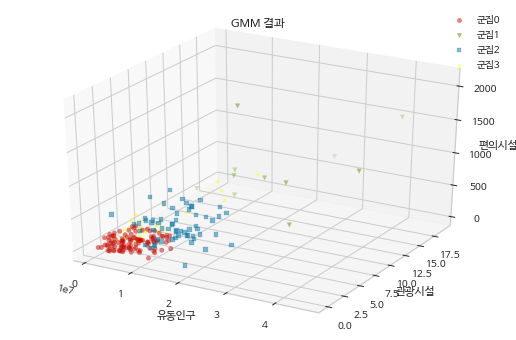

In [ ]:
유동인구_식음료_비식음료_통합_군집0 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 0, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집1 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 1, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집2 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 2, :].reset_index(drop=True)
유동인구_식음료_비식음료_통합_군집3 = 유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 3, :].reset_index(drop=True)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(유동인구_식음료_비식음료_통합_군집0.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집0.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집0.편의시설수.tolist(), color = 'r', alpha = 0.5, marker='o', label='군집0')
ax.scatter(유동인구_식음료_비식음료_통합_군집1.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집1.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집1.편의시설수.tolist(), color = 'g', marker='v', label='군집1')
ax.scatter(유동인구_식음료_비식음료_통합_군집2.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집2.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집2.편의시설수.tolist(), color = 'b', alpha = 0.5, marker='s', label='군집2')
ax.scatter(유동인구_식음료_비식음료_통합_군집3.유동인구.tolist(), 유동인구_식음료_비식음료_통합_군집3.관광시설수.tolist(),
           유동인구_식음료_비식음료_통합_군집3.편의시설수.tolist(), color = 'yellow', alpha = 0.5, marker='*', label='군집3')

ax.set_xlabel('유동인구')
ax.set_ylabel('관광시설')
ax.set_zlabel('편의시설')

plt.title('GMM 결과')
plt.legend()
plt.show()

# 결과 종합

클러스터링 결과,<br>
- k-means 클러스터링 : **군집 Label 2** <br>
- k-medoids 클러스터링 : **군집 Label 1** <br>
- 계층적 클러스터링 : **군집 Label 0** <br>
- GMM : **군집 Label 1**

다음 Label의 행정동이 유동인구, 관람시설, 편의시설이 가장 높은 것으로 나타났다.

In [ ]:
# 행정동별 클러스터링 결과 csv 출력
유동인구_식음료_비식음료_통합.loc[:, ['행정동명', 'K_means_군집', 'K_medoids_군집', '계층적_군집', 'GMM_군집']]

,행정동명,K_means_군집,K_medoids_군집,계층적_군집,GMM_군집
0,중앙동,3,3,2,3
1,동광동,0,3,3,3
2,대청동,0,0,3,3
3,보수동,0,0,3,0
4,부평동,0,0,3,0
...,...,...,...,...,...
200,기장읍,2,1,0,1
201,장안읍,3,3,2,3
202,정관읍,2,1,0,1
203,일광읍,1,1,1,2


In [ ]:
# 유동인구_식음료_비식음료_통합.loc[:, ['행정동명', 'K_means_군집', 'K_medoids_군집', '계층적_군집', 'GMM_군집']].to_csv("행정동별 클러스터 결과.csv", index = False)

In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_means_군집 == 2, '행정동명'].tolist()

['부전2동', '대연3동', '장전2동', '명지1동', '녹산동', '괘법동', '기장읍', '정관읍']

In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.K_medoids_군집 == 1, '행정동명'].tolist()

['범일2동',
 '부전2동',
 '전포1동',
 '수민동',
 '명륜동',
 '온천1동',
 '온천3동',
 '대연3동',
 '용호1동',
 '화명3동',
 '우1동',
 '우2동',
 '중1동',
 '좌2동',
 '반여1동',
 '재송1동',
 '하단1동',
 '하단2동',
 '다대1동',
 '장전2동',
 '남산동',
 '명지1동',
 '녹산동',
 '거제1동',
 '연산9동',
 '괘법동',
 '기장읍',
 '정관읍',
 '일광읍']

In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.계층적_군집 == 0, '행정동명'].tolist()

['부전2동', '대연3동', '우2동', '명지1동', '기장읍', '정관읍']

In [ ]:
유동인구_식음료_비식음료_통합.loc[유동인구_식음료_비식음료_통합.GMM_군집 == 1, '행정동명'].tolist()

['범일2동',
 '부전2동',
 '온천1동',
 '대연3동',
 '우2동',
 '장전2동',
 '명지1동',
 '녹산동',
 '괘법동',
 '기장읍',
 '정관읍']

In [ ]:
# Voting을 통한 최종 행정동 선정
유동인구_식음료_비식음료_통합.loc[(유동인구_식음료_비식음료_통합.K_means_군집 == 2)|(유동인구_식음료_비식음료_통합.K_medoids_군집 == 1)|
                     (유동인구_식음료_비식음료_통합.계층적_군집 == 0)|(유동인구_식음료_비식음료_통합.GMM_군집 == 1)]

,행정동명,주민등록인구,유동인구,관광시설수,식음료_편의시설수,비식음료_편의시설수,편의시설수,K_means_군집,K_medoids_군집,계층적_군집,GMM_군집
32,범일2동,7837,1.222985e+07,7,590,108,698,1,1,1,1
46,부전2동,10699,2.241646e+07,6,1862,249,2111,2,1,0,1
51,전포1동,21221,1.391334e+07,2,914,65,979,1,1,3,2
65,수민동,31658,1.678040e+07,3,587,126,713,1,1,1,2
67,명륜동,26401,1.776636e+07,3,483,119,602,1,1,3,2
68,온천1동,22339,2.020704e+07,7,548,161,709,1,1,1,1
70,온천3동,37727,2.927943e+07,0,384,112,496,1,1,1,2
79,대연3동,33110,3.491832e+07,4,1104,164,1268,2,1,0,1
83,용호1동,43228,1.969724e+07,4,382,105,487,1,1,3,2
101,화명3동,28938,1.433917e+07,4,539,134,673,1,1,1,2


⚓ Target 행정동 <br>

- 범일2동(동구) (NEW!)
- 부전2동(부산진구)
- 온천1동(동래구)
- 대연3동(남구)
- 우2동(해운대구)
- 장전2동(금정구)
- 명지1동(강서구)
- 녹산동(강서구)
- 괘법동(사상구)
- 기장읍(기장군)
- 정관읍(기장군)